In [5]:
%run ../initialize.ipynb

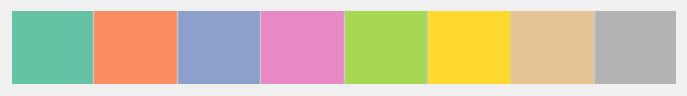

In [6]:
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Global functions

In [7]:
def get_window(window_type, n, partition_cols, date_orderby_col):
    '''accepts window type (days, games, seasons),
     size of window n,
     and window fields (partition and sort), 
     and returns a spark Window'''
    assert type(partition_cols) is list
    assert type(date_orderby_col) is str
    assert type(n) is int
    assert window_type in ['games','days','seasons']
    
    from pyspark.sql.window import Window
    if window_type == 'games':
        ## fixed number of games
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).desc())\
                  .rowsBetween(1, n)

    elif window_type == 'days':
        ## fixed number of days
        seconds = 24*60*60*n
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

    elif window_type == 'seasons':
        ## fixed number of seasons, including current
        ## n = 1 is YTD
        seconds = 24*60*60*(180 + 365*(n-1))
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

## Travel Features
* key: (game_id)
* table name: features.matchup

In [8]:
key = 'game_id'
out_tbl = 'features.travel'
features_list = []

In [27]:
game = spark.table('game').select('game_id','date','stadium','h_team_id',
                                  'v_team_id','is_neutral')
stadium = spark.table('stadium').select('stadium','lat','long','timezone',
                                        'stadium_home_team')

game.join(stadium, on='stadium').limit(5).toPandas()

,stadium,game_id,date,h_team_id,v_team_id,is_neutral,lat,long,timezone,stadium_home_team
0,Edward Jones Dome,201511150ram,2015-11-15,ram,chi,0,38.63278,-90.18861,-6.0,['ram']
1,Qualcomm Stadium,201511090sdg,2015-11-09,sdg,chi,0,32.78306,-117.11944,-8.0,['sdg']
2,Ford Field,201510180det,2015-10-18,det,chi,0,42.34000,-83.04556,-5.0,['det']
3,Raymond James Stadium,201512270tam,2015-12-27,tam,chi,0,27.97583,-82.50333,-5.0,['tam']
4,Arrowhead Stadium,201510110kan,2015-10-11,kan,chi,0,39.04889,-94.48389,-6.0,['kan']


### Travel from last game

### Distance from home stadium